# Did Covid 19 Have an Impact on Crash Data in New York City?

# Data Collection

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from bs4 import BeautifulSoup
import requests
import os

In [175]:
#from google.colab import drive
#drive.mount('/content/drive')

In [176]:
file_path = 'Data/Motor_Vehicle_Collisions_-_Crashes_20241219.csv'
crash_data = pd.read_csv(file_path)

In [177]:
pd.set_option('display.max_columns', None)
#crash_data

In [178]:
desc_stats = crash_data.describe()
desc_stats

,ZIP CODE,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,671627.000000,973677.000000,973677.000000,1.048558e+06,1.048545e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,10869.642379,40.578727,-73.664390,3.210485e-01,1.485869e-03,5.420976e-02,7.095344e-04,2.892020e-02,1.239778e-04,2.340462e-01,6.284720e-04,4.036386e+06
std,541.461342,2.438952,4.618694,7.027846e-01,4.080277e-02,2.390199e-01,2.736944e-02,1.700006e-01,1.121917e-02,6.656528e-01,2.707364e-02,3.041015e+05
min,10000.000000,0.000000,-201.359990,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.405265e+06
25%,10453.000000,40.667340,-73.970480,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.773158e+06
50%,11208.000000,40.719760,-73.922554,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.037406e+06
75%,11249.000000,40.774292,-73.863560,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.299676e+06
max,11697.000000,41.126150,0.000000,4.000000e+01,8.000000e+00,2.700000e+01,6.000000e+00,3.000000e+00,2.000000e+00,4.000000e+01,4.000000e+00,4.778782e+06


#Data Cleaning

In [179]:
'''
Finding where the index of the column 'CONTRIBUTING FACTOR VEHICLE 1' is in the dataset.
'''
column_name = 'CONTRIBUTING FACTOR VEHICLE 1'
column_index = crash_data.columns.get_loc(column_name)

column_index

18

In [180]:
'''
Converted 'Crash Date' to datetime
Extracted the year and filter

'''
crash_data['CRASH DATE'] = pd.to_datetime(crash_data['CRASH DATE'])

crash_data['Year'] = crash_data['CRASH DATE'].dt.year
post_2016_crash_data = crash_data[crash_data['Year'] >= 2016]

post_2016_crash_data = post_2016_crash_data.drop(columns=['Year'])


In [181]:
'''
In this part of the Data Cleaning Process I am filtering the dates to only represent data post 2016 and
getting rid of 'Unspecified' or blank values in the Vehicle 1 Contributing Factor column.

'''

post_2016_crash_data = post_2016_crash_data[
    ~(post_2016_crash_data['VEHICLE TYPE CODE 1'].isna() |
      (post_2016_crash_data['VEHICLE TYPE CODE 1'] == 'Unspecified'))
]

post_2016_crash_data = post_2016_crash_data[
    ~(post_2016_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isna() |
      (post_2016_crash_data['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unspecified'))
]

# Sorted by 'CRASH DATE' in descending order
post_2016_crash_data = post_2016_crash_data.sort_values(by=['CRASH DATE'], ascending=False)


post_2016_crash_data


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
271000,2024-12-01,0:10,BROOKLYN,11208.0,40.688400,-73.867455,"(40.6884, -73.867455)",ETNA ST,ELDERT LN,NaN,0.0,0.0,0,0,0,0,0,0,Other Vehicular,NaN,NaN,NaN,NaN,4775301,Sedan,NaN,NaN,NaN,NaN
270710,2024-12-01,9:06,QUEENS,11373.0,40.747105,-73.886540,"(40.747105, -73.88654)",NaN,NaN,40-03 79 ST,0.0,0.0,0,0,0,0,0,0,Turning Improperly,Unspecified,NaN,NaN,NaN,4775567,Sedan,NaN,NaN,NaN,NaN
272901,2024-12-01,22:38,BRONX,10467.0,40.885693,-73.861640,"(40.885693, -73.86164)",WHITE PLAINS RD,E 222 ST,NaN,1.0,0.0,1,0,0,0,0,0,Unsafe Speed,NaN,NaN,NaN,NaN,4775742,E-Bike,NaN,NaN,NaN,NaN
114730,2024-11-30,11:05,BROOKLYN,11208.0,40.678180,-73.870700,"(40.67818, -73.8707)",LIBERTY AVE,CRESCENT ST,NaN,0.0,0.0,0,0,0,0,0,0,Unsafe Speed,Unspecified,NaN,NaN,NaN,4775297,Sedan,NaN,NaN,NaN,NaN
114984,2024-11-30,20:30,NaN,NaN,NaN,NaN,NaN,FDR DRIVE EXIT 7 SOUTHBOUND,E 25 STREET PEDESTRIAN OPAS,NaN,0.0,0.0,0,0,0,0,0,0,Other Vehicular,Driver Inexperience,NaN,NaN,NaN,4775599,Sedan,Sedan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985771,2016-03-22,0:00,MANHATTAN,10033.0,NaN,NaN,NaN,AMSTERDAM AVENUE,WEST 177 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,3410525,Van,4 dr sedan,NaN,NaN,NaN
979346,2016-03-22,15:45,QUEENS,11372.0,NaN,NaN,NaN,BROADWAY,72 STREET,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3429278,4 dr sedan,NaN,NaN,NaN,NaN
978596,2016-03-21,1:35,NaN,NaN,NaN,NaN,NaN,3 AVENUE,EAST 184 STREET,NaN,2.0,0.0,2,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3413595,4 dr sedan,NaN,NaN,NaN,NaN
984805,2016-03-19,18:20,NaN,NaN,NaN,NaN,NaN,4 AVENUE,67 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,3416658,4 dr sedan,4 dr sedan,NaN,NaN,NaN


# Data Visualization
---------
###Top 10 Contributing Factors to Crashes

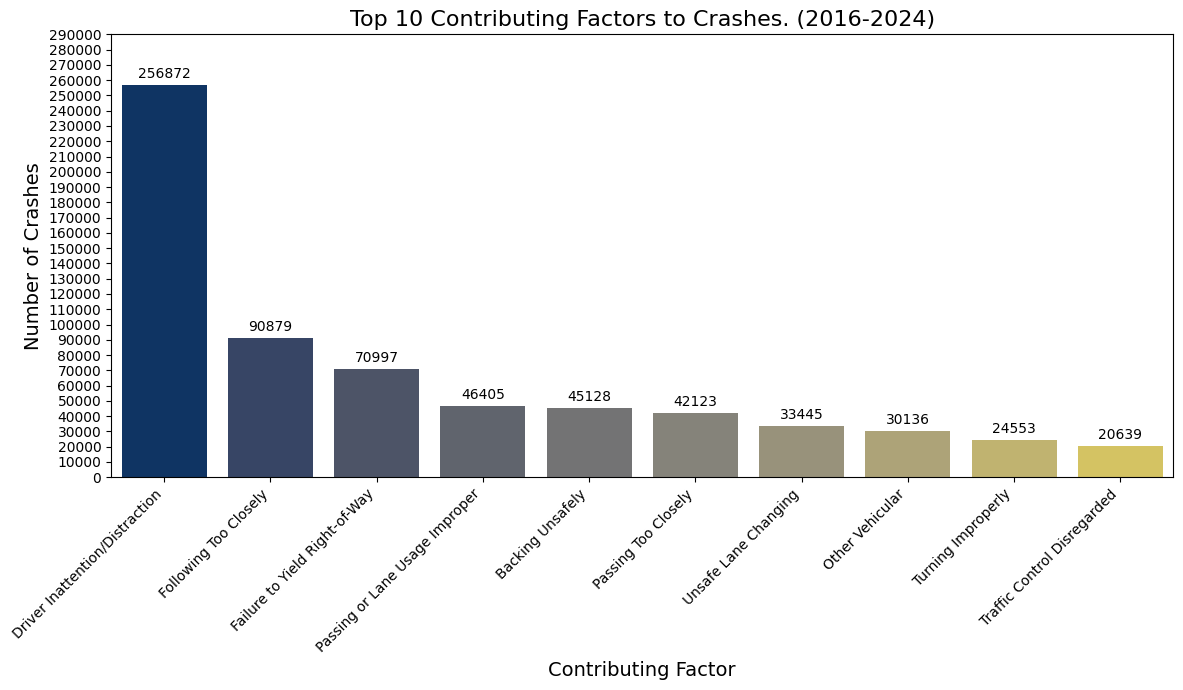

In [182]:
'''
Displaying the Top 10 Contributing factors to Crashes from 2016 to 2024

'''

top_factors = post_2016_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)
max_val = top_factors.values.max()



ticks = list(range(0, min(20000, max_val) + 1, 10000))

if max_val > 20000:
    tick_val = 20000
    while tick_val < max_val * 1.1:
        tick_val += 10000
        ticks.append(tick_val)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=top_factors.index,
                 y=top_factors.values,
                 hue=top_factors.index,
                 palette="cividis",
                 legend=False)

plt.title('Top 10 Contributing Factors to Crashes. (2016-2024)', fontsize=16)
plt.xlabel('Contributing Factor', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.ylim(0, max_val * 1.1)
plt.yticks(ticks)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


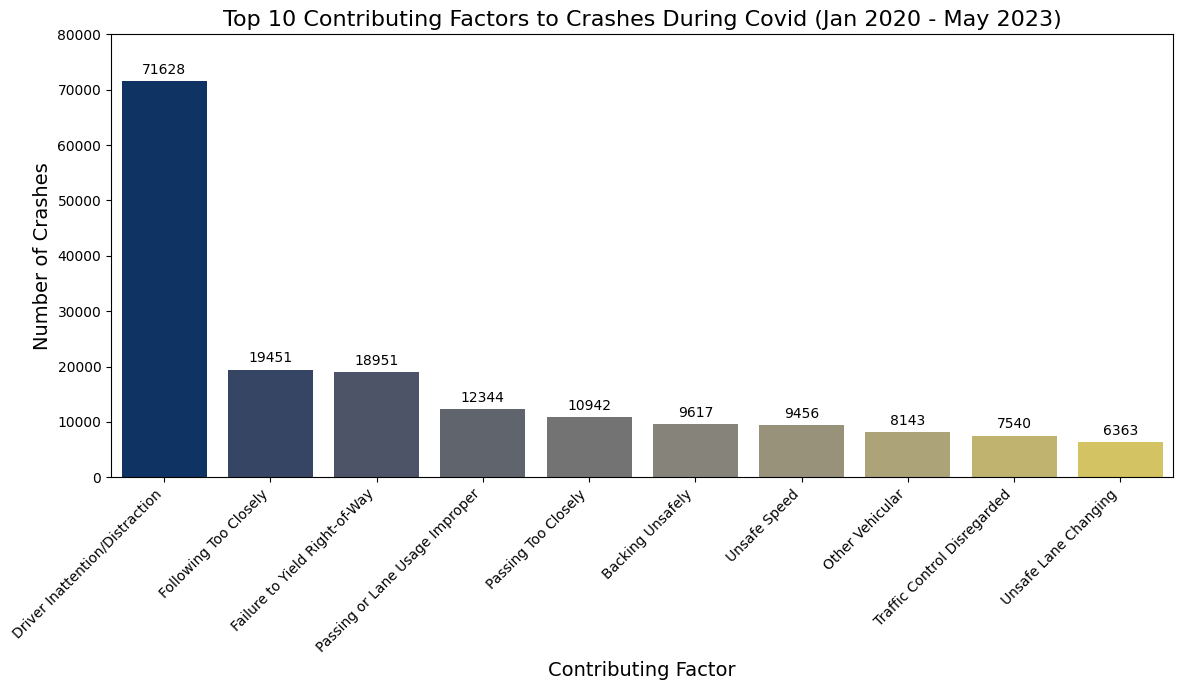

In [183]:
'''
Displaying the Top 10 Contributing factors to Crashes from 2020-2023

'''

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-05-31')
filtered_crash_data = post_2016_crash_data[(post_2016_crash_data['CRASH DATE'] >= start_date) & (post_2016_crash_data['CRASH DATE'] <= end_date)]


top_factors = filtered_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)
max_val = top_factors.values.max()

ticks = list(range(0, min(20000, max_val) + 1, 10000))

if max_val > 20000:
    tick_val = 20000
    while tick_val < max_val * 1.1:
        tick_val += 10000
        ticks.append(tick_val)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=top_factors.index,
                 y=top_factors.values,
                 hue=top_factors.index,
                 palette="cividis",
                 legend=False)

plt.title('Top 10 Contributing Factors to Crashes During Covid (Jan 2020 - May 2023)', fontsize=16)
plt.xlabel('Contributing Factor', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.ylim(0, max_val * 1.1)
plt.yticks(ticks)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

What are the top 3 contributing factors that cause the most crashes?
- During the Pandemic and throughout the entire dataset the reason for crashes  remained the same.


> *  Driver Inattention/Distraction
> *  Following Too Closely
> *  Faulure to Yield Right-of-Way

______________________________________________________________
###Top 10 Types of Vehicles in Crashes

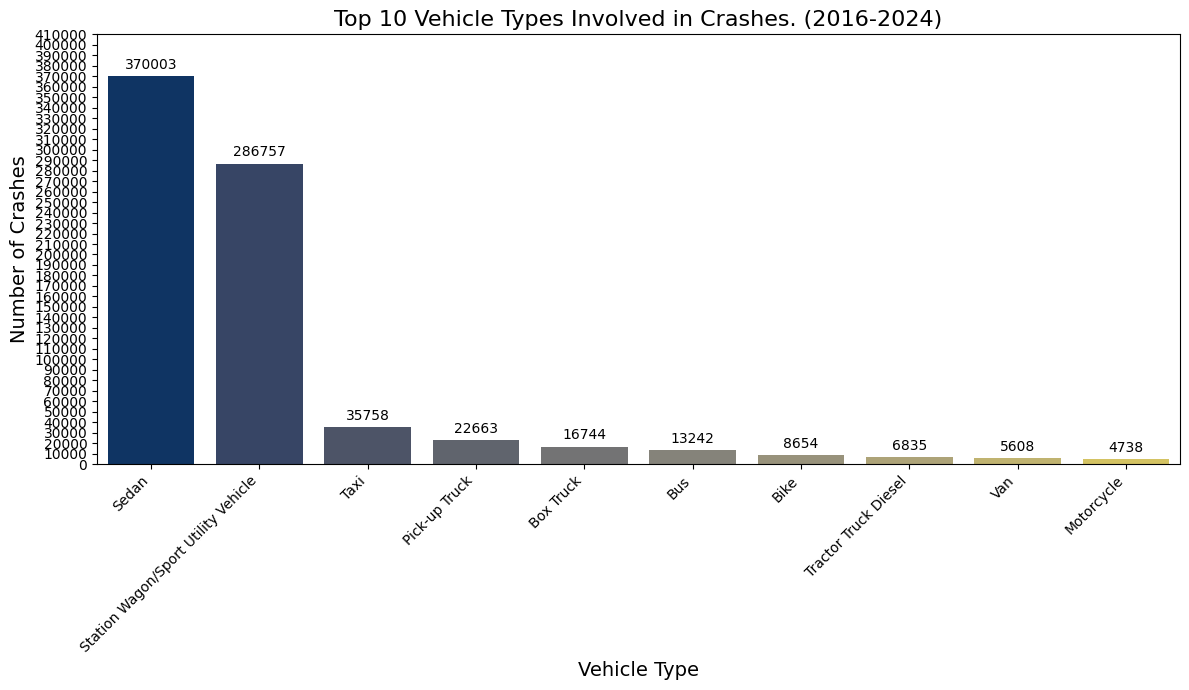

In [184]:
'''
Displaying the Top 10 types of vehicles involved in the crashses from 2016 to 2024
'''

top_vehicle_types = post_2016_crash_data['VEHICLE TYPE CODE 1'].value_counts().head(10)
max_val = top_vehicle_types.values.max()


ticks = list(range(0, min(20000, max_val) + 1, 10000))

if max_val > 20000:
    tick_val = 20000
    while tick_val < max_val * 1.1:
        tick_val += 10000
        ticks.append(tick_val)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=top_vehicle_types.index,
                 y=top_vehicle_types.values,
                 hue=top_vehicle_types.index,
                 palette="cividis",
                 legend=False)

plt.title('Top 10 Vehicle Types Involved in Crashes. (2016-2024)', fontsize=16)
plt.xlabel('Vehicle Type', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.ylim(0, max_val * 1.1)
plt.yticks(ticks)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()




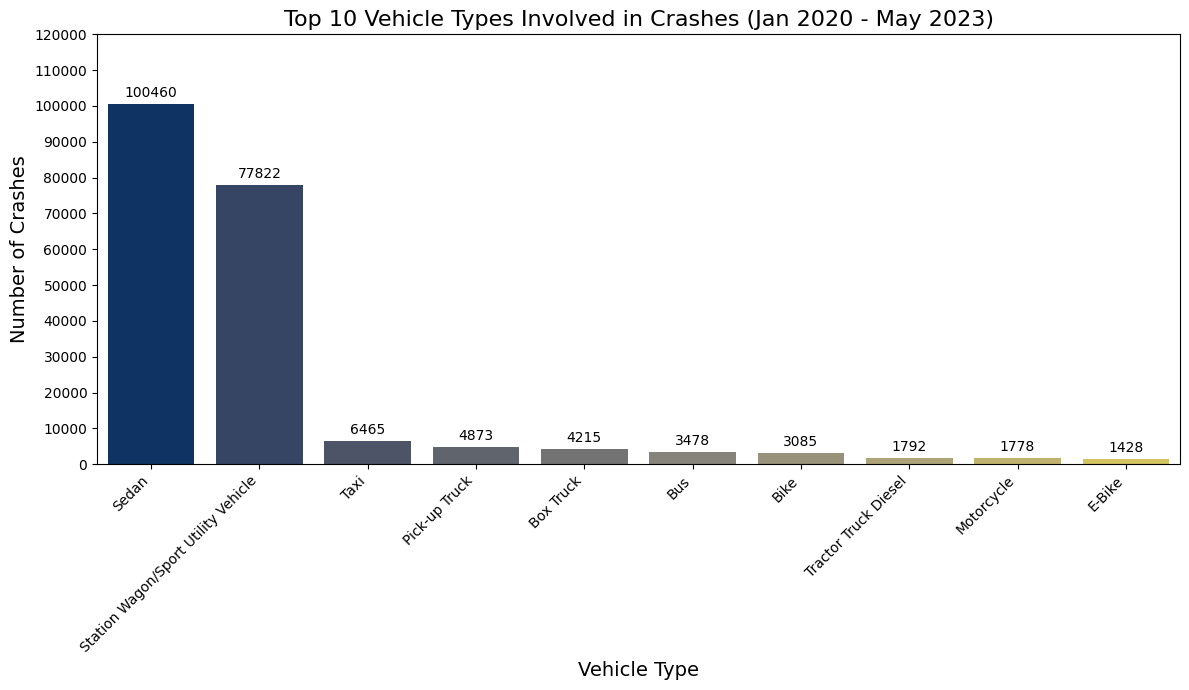

In [185]:
'''
Displaying the Top 10 types of vehicles involved in the crashses from 2020-2023
'''

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-05-31')
filtered_crash_data = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= start_date) &
    (post_2016_crash_data['CRASH DATE'] <= end_date)
]

top_vehicle_types = filtered_crash_data['VEHICLE TYPE CODE 1'].value_counts().head(10)
max_val = top_vehicle_types.values.max()


ticks = list(range(0, min(20000, max_val) + 1, 10000))

if max_val > 20000:
    tick_val = 20000
    while tick_val < max_val * 1.1:
        tick_val += 10000
        ticks.append(tick_val)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=top_vehicle_types.index,
                 y=top_vehicle_types.values,
                 hue=top_vehicle_types.index,
                 palette="cividis",
                 legend=False)

plt.title('Top 10 Vehicle Types Involved in Crashes (Jan 2020 - May 2023)', fontsize=16)
plt.xlabel('Vehicle Type', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.ylim(0, max_val * 1.1)
plt.yticks(ticks)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

##What are the top 3 vehicles that were most involved in crashes?
- During the Pandemic and throughout the entire dataset the vehicle types involved in the most crashes remained the same.


> *   Sedan
> *   Station Wagon / Sports Utility Vehicles
> *   Taxis

##The Question
#### Why are sedans, station wagons, and passenger vehicles involved in a larger number of crashes,
#### injuries, and deaths when compared to other types of vehicles?

## Explanation

#### **Prevalence on the road:** Sedans and other passenger cars make up the vast majority of vehicles
####   in use. With more of them on the road, it’s statistically more likely they’ll be involved in
####  a greater number of accidents.





______________________________________________________________
###Total Injuries and Deaths by Person Type

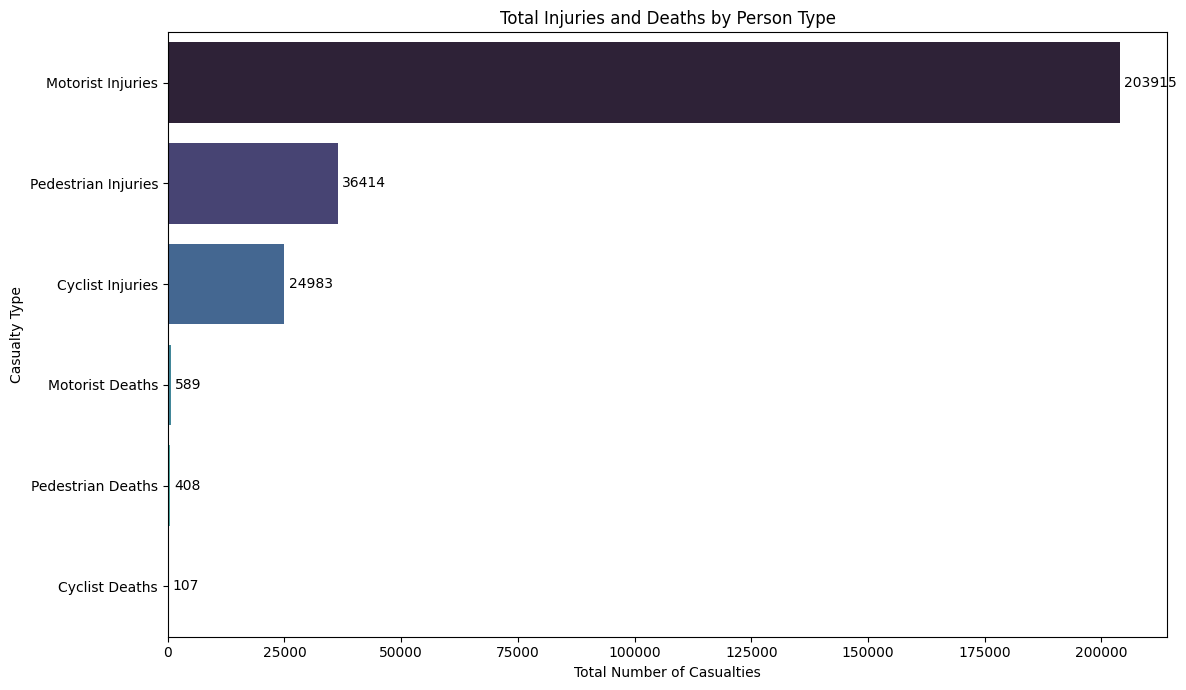

In [186]:
'''
 Aggregating the data
 Graphing the types of crashes within this dataset and their frequencies.

'''

types_of_casualties = {
    'Motorist Injuries': post_2016_crash_data['NUMBER OF MOTORIST INJURED'].sum(),
    'Pedestrian Injuries': post_2016_crash_data['NUMBER OF PEDESTRIANS INJURED'].sum(),
    'Cyclist Injuries': post_2016_crash_data['NUMBER OF CYCLIST INJURED'].sum(),
    'Motorist Deaths': post_2016_crash_data['NUMBER OF MOTORIST KILLED'].sum(),
    'Pedestrian Deaths': post_2016_crash_data['NUMBER OF PEDESTRIANS KILLED'].sum(),
    'Cyclist Deaths': post_2016_crash_data['NUMBER OF CYCLIST KILLED'].sum(),
}

casualties_df = pd.DataFrame(list(types_of_casualties.items()), columns=['Casualty Type', 'Total'])

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Total', y='Casualty Type', data=casualties_df, hue='Casualty Type', palette="mako", legend=False)
plt.title('Total Injuries and Deaths by Person Type')
plt.xlabel('Total Number of Casualties')
plt.ylabel('Casualty Type')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


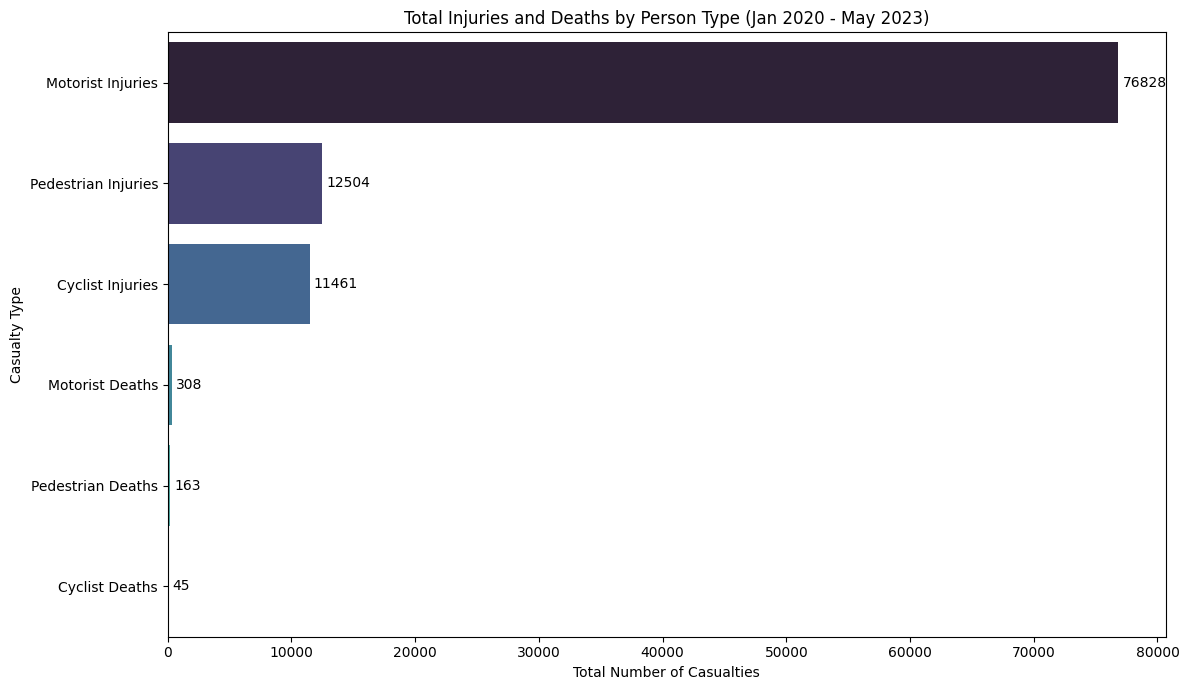

In [187]:
'''
Aggregating the data for Jan 2020 - May 2023
Graphing the types of crashes within this dataset and their frequencies.

'''

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-05-31')
filtered_crash_data = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= start_date) &
    (post_2016_crash_data['CRASH DATE'] <= end_date)
]

types_of_casualties = {
    'Motorist Injuries': filtered_crash_data['NUMBER OF MOTORIST INJURED'].sum(),
    'Pedestrian Injuries': filtered_crash_data['NUMBER OF PEDESTRIANS INJURED'].sum(),
    'Cyclist Injuries': filtered_crash_data['NUMBER OF CYCLIST INJURED'].sum(),
    'Motorist Deaths': filtered_crash_data['NUMBER OF MOTORIST KILLED'].sum(),
    'Pedestrian Deaths': filtered_crash_data['NUMBER OF PEDESTRIANS KILLED'].sum(),
    'Cyclist Deaths': filtered_crash_data['NUMBER OF CYCLIST KILLED'].sum(),
}

casualties_df = pd.DataFrame(list(types_of_casualties.items()), columns=['Casualty Type', 'Total'])

plt.figure(figsize=(12, 7))
ax = sns.barplot(x='Total', y='Casualty Type', data=casualties_df, hue='Casualty Type', palette="mako", legend=False)
plt.title('Total Injuries and Deaths by Person Type (Jan 2020 - May 2023)')
plt.xlabel('Total Number of Casualties')
plt.ylabel('Casualty Type')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()


#Time Series Analysis | Data Analysis

______________________________________________________________

# Pre-Pandemic Crash Data

<ipython-input-188-15db0606d1cd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crash_data['CRASH TIME'] = pd.to_datetime(filtered_crash_data['CRASH TIME'], format='%H:%M')
<ipython-input-188-15db0606d1cd>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crash_data['Hour of Day'] = filtered_crash_data['CRASH TIME'].dt.hour


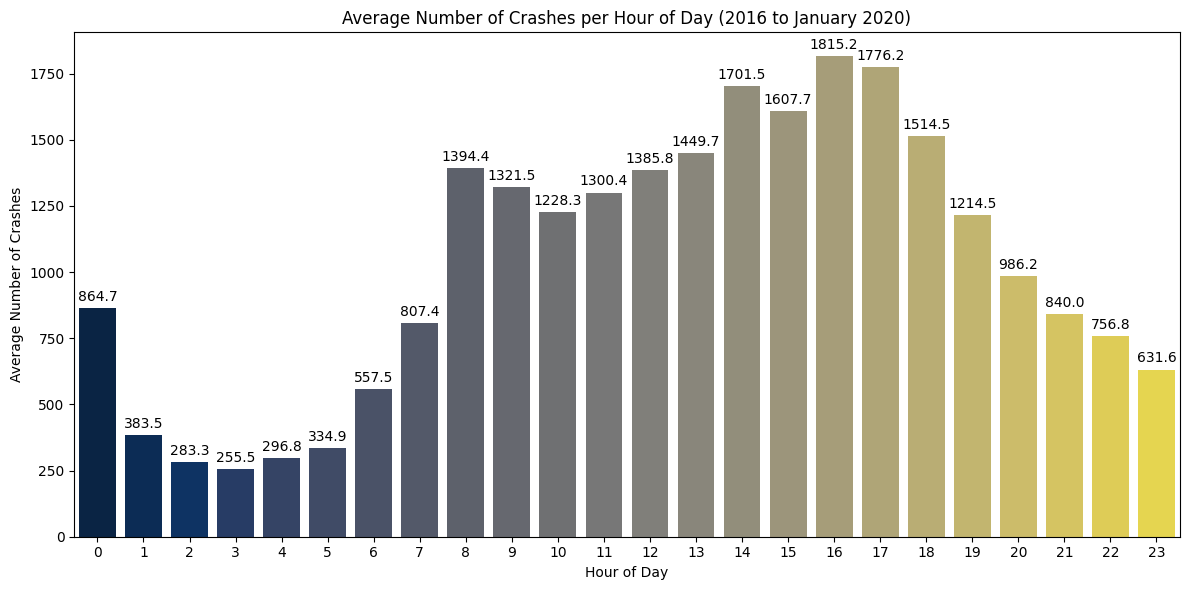

In [188]:
'''
Time Series Analysis of Crash Data from 2016 to January 2020

Finding what time most crashes occur during this period.

'''

post_2016_crash_data['CRASH DATE'] = pd.to_datetime(post_2016_crash_data['CRASH DATE'])

filtered_crash_data = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= '2016-01-01') &
    (post_2016_crash_data['CRASH DATE'] < '2020-02-01')]

filtered_crash_data['CRASH TIME'] = pd.to_datetime(filtered_crash_data['CRASH TIME'], format='%H:%M')

filtered_crash_data['Hour of Day'] = filtered_crash_data['CRASH TIME'].dt.hour

average_crashes_per_hour = filtered_crash_data.groupby('Hour of Day').size() / filtered_crash_data['Hour of Day'].nunique()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=average_crashes_per_hour.index,
                 y=average_crashes_per_hour.values,
                 hue=average_crashes_per_hour.index,
                 palette="cividis",
                 legend=False)

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f', label_type='edge', padding=3)

plt.title('Average Number of Crashes per Hour of Day (2016 to January 2020)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Crashes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

#Pandemic Crash Data

______________________________________________________________

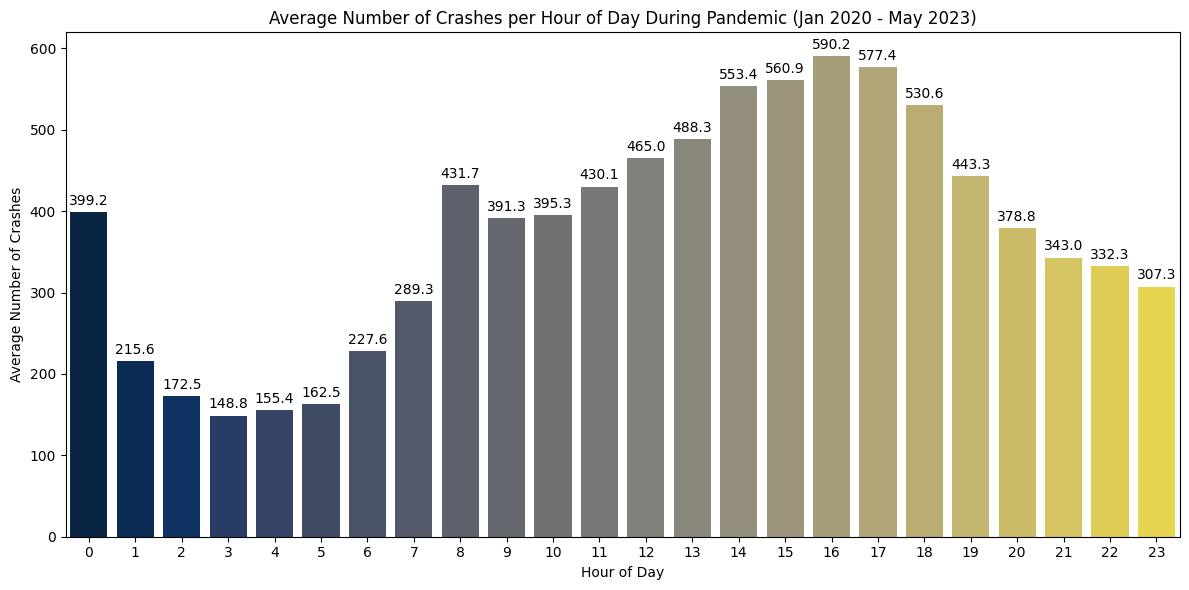

In [189]:
'''
Working with Pandemic data only

'''
start_date = '2020-01-01'
end_date = '2023-05-31'

post_2016_crash_data['CRASH DATE'] = pd.to_datetime(post_2016_crash_data['CRASH DATE'])

pandemic_crash_data = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= start_date) &
    (post_2016_crash_data['CRASH DATE'] <= end_date)
].copy()

pandemic_crash_data['CRASH TIME'] = pd.to_datetime(pandemic_crash_data['CRASH TIME'], format='%H:%M')

pandemic_crash_data['Hour of Day'] = pandemic_crash_data['CRASH TIME'].dt.hour

average_crashes_per_hour = pandemic_crash_data.groupby('Hour of Day').size() / pandemic_crash_data['Hour of Day'].nunique()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=average_crashes_per_hour.index,
                 y=average_crashes_per_hour.values,
                 hue=average_crashes_per_hour.index,
                 palette="cividis",
                 legend=False)

for i in ax.containers:
    ax.bar_label(i, fmt='%.1f', label_type='edge', padding=3)

plt.title('Average Number of Crashes per Hour of Day During Pandemic (Jan 2020 - May 2023)')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Crashes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()



## Percent Change in Crashes from Pre-Pandemic and Pandemic.

In [190]:
# Pre-pandemic period
pre_pandemic_start_date = '2016-01-01'
pre_pandemic_end_date = '2020-01-01'

pre_pandemic_crashes = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= pre_pandemic_start_date) &
    (post_2016_crash_data['CRASH DATE'] < pre_pandemic_end_date)
]
total_pre_pandemic_crashes = len(pre_pandemic_crashes)

# Pandemic period
pandemic_start_date = '2020-01-01'
pandemic_end_date = '2023-05-31'

pandemic_crashes = post_2016_crash_data[
    (post_2016_crash_data['CRASH DATE'] >= pandemic_start_date) &
    (post_2016_crash_data['CRASH DATE'] <= pandemic_end_date)
]
total_pandemic_crashes = len(pandemic_crashes)

# Calculate percent change
percent_change = (
    (total_pandemic_crashes - total_pre_pandemic_crashes) / total_pre_pandemic_crashes
) * 100

print(f"Percent change in crashes during the pandemic compared to pre-pandemic levels: {percent_change:.2f}%")

Percent change in crashes during the pandemic compared to pre-pandemic levels: -62.95%


# How did the Pandemic effect crashes in New York City?

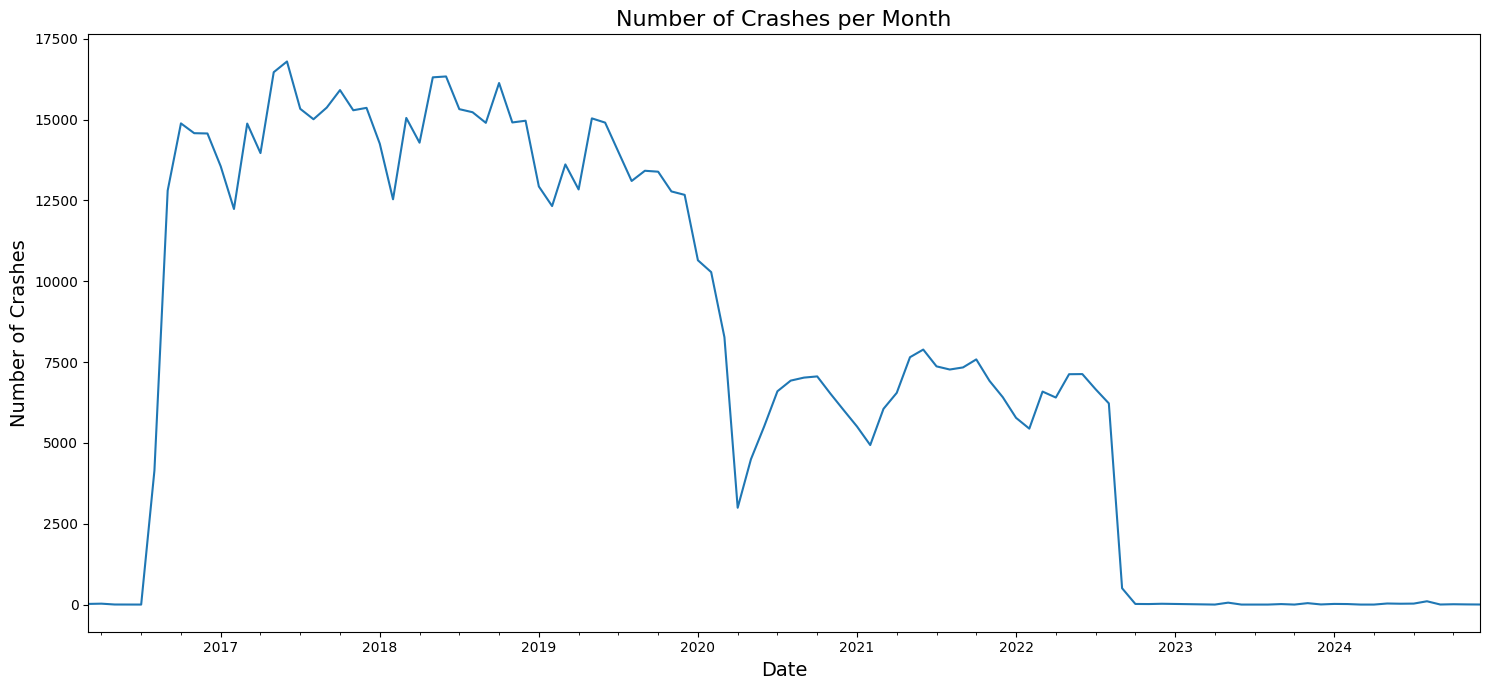

In [191]:
'''
The purpose of this graph is to show how the Pandemic effected the number of crashes.
'''

post_2016_crash_data['CRASH DATE'] = pd.to_datetime(post_2016_crash_data['CRASH DATE'])

monthly_crashes = post_2016_crash_data.groupby(post_2016_crash_data['CRASH DATE'].dt.to_period("M")).size()

plt.figure(figsize=(15, 7))
monthly_crashes.plot()
plt.title('Number of Crashes per Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.tight_layout()
plt.show()

In [192]:
import pandas as pd

def calculate_crash_dropoff(monthly_crashes):
  """Calculates the drop-off in crashes from pre-pandemic to pandemic levels.

  This function takes a pandas Series representing the number of crashes per month
  and calculates the average crashes for the pre-pandemic and pandemic periods.
  It then calculates the drop-off in crashes and the percent drop-off.

  Args:
    monthly_crashes: A pandas Series with the number of crashes per month,
      indexed by month-year (e.g., '2020-01').

  Returns:
    A tuple containing:
      - average_pre_pandemic_crashes: The average number of crashes per month
        during the pre-pandemic period.
      - average_pandemic_crashes: The average number of crashes per month
        during the pandemic period.
      - drop_off: The difference between the average pre-pandemic and pandemic
        crashes.
      - percent_drop_off: The percentage drop-off in crashes from pre-pandemic
        to pandemic levels.
  """
  # Pre-pandemic period
  pre_pandemic_start_date = '2016-01'
  pre_pandemic_end_date = '2019-12'

  pre_pandemic_monthly_crashes = monthly_crashes[
      (monthly_crashes.index >= pre_pandemic_start_date) &
      (monthly_crashes.index <= pre_pandemic_end_date)
  ]
  average_pre_pandemic_crashes = pre_pandemic_monthly_crashes.mean()

  # Pandemic period
  pandemic_start_date = '2020-01'
  pandemic_end_date = '2023-05'

  pandemic_monthly_crashes = monthly_crashes[
      (monthly_crashes.index >= pandemic_start_date) &
      (monthly_crashes.index <= pandemic_end_date)
  ]
  average_pandemic_crashes = pandemic_monthly_crashes.mean()

  # Calculated drop-off
  drop_off = average_pre_pandemic_crashes - average_pandemic_crashes
  percent_drop_off = (drop_off / average_pre_pandemic_crashes) * 100

  return average_pre_pandemic_crashes, average_pandemic_crashes, drop_off, percent_drop_off


avg_pre, avg_pan, dropoff, percent_dropoff = calculate_crash_dropoff(monthly_crashes)

print(f"Average pre-pandemic crashes per month: {avg_pre:.2f}")
print(f"Average pandemic crashes per month: {avg_pan:.2f}")
print(f"Drop-off in crashes: {dropoff:.2f}")
print(f"Percent drop-off: {percent_dropoff:.2f}%")

Average pre-pandemic crashes per month: 12941.04
Average pandemic crashes per month: 5677.79
Drop-off in crashes: 7263.25
Percent drop-off: 56.13%


#Cause for Drop in Crashes During Pandemic? | Web Scraping | Supporting Data



- Traffic Accidents Decrease: 47% (Louisiana, March-May 2020)
Accidents Involving Injuries Decrease: 46% (Louisiana, March-May 2020)
- Accidents Where an Ambulance Was Called Decrease: 41% (Louisiana, March-May 2020)
- Fatal Accidents: No significant decrease
- Estimated Reduction in Car Crash Costs: $21 billion nationally (March-May 2020)
Demographic Impact:
- Males, nonwhite drivers, and individuals aged 25–64 saw smaller reductions in traffic accidents.

In [193]:
def scrape_sciencedaily(url):
  """Scrapes data from a ScienceDaily article and extracts relevant metrics.

  This function fetches the HTML content of a ScienceDaily article using the
  requests library, parses it with BeautifulSoup, and extracts metrics
  related to accidents, percentages, or billion-dollar figures.
  It includes error handling for HTTP errors, particularly 403 Forbidden errors,
  by adding a User-Agent header to the request to mimic a web browser.

  Args:
    url: The URL of the ScienceDaily article to scrape.

  Returns:
    A list of strings containing the extracted metrics.

  Raises:
    requests.exceptions.HTTPError: If an HTTP error occurs during the request.
    This includes 403 Forbidden errors, which are handled by adding a User-Agent
    header to the request.
  """
  # Was giving me an issue when trying to do a normal request, so I used  headers to mimic a web browser
  headers = {
      "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()

  soup = BeautifulSoup(response.content, "html.parser")

  metrics = []
  for paragraph in soup.find_all("p"):
      text = paragraph.get_text().strip()
      if "%" in text or "billion" in text or "accidents" in text:
          metrics.append(text)

  return metrics

url = "https://www.sciencedaily.com/releases/2022/03/220307131948.htm"
extracted_metrics = scrape_sciencedaily(url)
print("Extracted Metrics:")
for metric in extracted_metrics:
    print("-", metric)

Extracted Metrics:
- Research from Rensselaer Polytechnic Institute shows that traffic accidents decreased by nearly half during the two-month period at the start of the COVID-19 pandemic when residents of most states were under a stay-at-home order.
- Using a detailed data set from the Louisiana Department of Transportation and Development, Jason Huh, an assistant professor in the Department of Economics at Rensselaer, found that traffic accidents in Louisiana decreased by 47% during March and May 2020 when Louisiana Governor John Bel Edwards issued a series of orders that closed businesses and schools, limiting mobility throughout the state. Accidents involving injuries decreased by 46% and those where an ambulance was called fell by 41%.
- The number of fatal accidents, however, showed no significant decrease.
- Dr. Huh's research also showed that the decline in accidents was not equal across all demographics. Traffic accidents involving males, nonwhite drivers, and individuals in t

* Becuase many givernment website that hold these traffic metrics do not allow for webscraping I opted to scrape key metrics that support my findings from this univesity study.